In [88]:
import networkx as nx
import random
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

from IPython.display import HTML
from GraphGenusGenerator import GraphGenusGenerator
from HC_Algorithm import hill_climb
from SimulatedAnnealing import simulated_annealing
from RHC_Algorithm import random_hill_climb
from Genetic_Algorithm import Genetic_Algorithm
from mlrose_hiive.algorithms.decay import GeomDecay
from mlrose_hiive.algorithms.decay import ArithDecay
from mlrose_hiive.algorithms.decay import ExpDecay

In [89]:
seed=random.randint(0, 2**32 - 1)
max_iter = np.inf
times_to_run = 1000
popsize = 200
number_of_nodes = 7
restarts = 0
attemps = 1000
complete_graph = True
record_file = "TempData.csv"
bracket = [1,1,1,1]

graph_type = "complete" 
# complete, complete_bipartite, billiards 

algorithm_name = "Simulated_Annealing" 
# Random_Hill_Climb, Hill_Climb, Simulated_Annealing, Genetic

problem = GraphGenusGenerator.generate(seed=seed, number_of_nodes=number_of_nodes, graph_type=graph_type, bracket=bracket)

mutation_prob = 0.2/len(problem.adj_list)

# Print starting data
print("Starting State:", problem.adj_list)
print("Seed:", seed)
print("Max Iterations:", max_iter)


Starting State: {0: [1, 2, 3, 4, 5, 6], 1: [0, 2, 3, 4, 5, 6], 2: [0, 1, 3, 4, 5, 6], 3: [0, 1, 2, 4, 5, 6], 4: [0, 1, 2, 3, 5, 6], 5: [0, 1, 2, 3, 4, 6], 6: [0, 1, 2, 3, 4, 5]}
Seed: 258435641
Max Iterations: inf


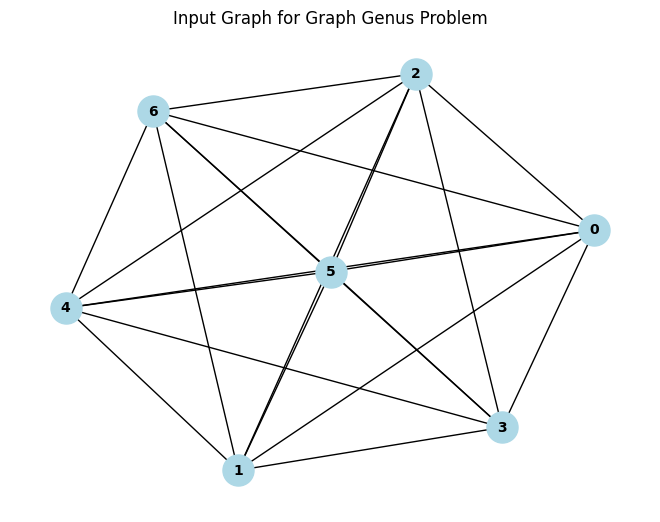

In [81]:
# Get the adjacency list (which is a graph object)
adj_list = problem.adj_list
graph = nx.Graph(adj_list)

def is_power_of_two(n):
    return (n != 0) and (n & (n - 1)) == 0

# Draw the generated graph
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [26]:
# Function to check if a number is a power of two
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0

# Function to get the best result from the CSV file
def get_best_result(file_path):
    df = pd.read_csv(file_path)
    min_fitness = df['Fitness'].min()
    first_min_fitness_index = df[df['Fitness'] == min_fitness].index[0]
    best_result = df.loc[first_min_fitness_index]
    return best_result

# Function to save the best result to a file
def save_best_result(best_result, number_of_nodes, bracket, graph_type, seed, algorithm_name, listed_fitness_over_time, file_path="best_results.csv"):
    if graph_type == "billiards":
        data = {
            'Algorithm': [algorithm_name],
            'Bracket': [bracket],
            'Final Fitness': [best_result['Fitness']],
            'Plato': [best_result['Iteration']],
            'Time': [best_result['Time']],
            'Seed': [seed],
            'Fitness List': [listed_fitness_over_time],
            'Final State': [best_result['State']]
        }
    else: 
        data = {
            'Algorithm': [algorithm_name],
            'Number of Nodes': [number_of_nodes],
            'Final Fitness': [best_result['Fitness']],
            'Plato': [best_result['Iteration']],
            'Time': [best_result['Time']],
            'Seed': [seed],
            'Fitness List': [listed_fitness_over_time],
            'Final State': [best_result['State']]
        }
    df = pd.DataFrame(data)
    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, append the new data
        df.to_csv(file_path, mode='a', header=False, index=False)
    else:
        # If the file doesn't exist, create a new one
        df.to_csv(file_path, index=False)

# Generate new seeds from the original seed
def generate_seeds(original_seed, count):
    random.seed(original_seed)
    return [random.randint(0, 1000000) for _ in range(count)]

def get_fitness_over_time(filtered_data):
    fitness_values = filtered_data['Fitness'].tolist()
    return fitness_values

def random_hill_climb_get_fitness_over_time(iteration_data):
    power = 0
    FitnessList = iteration_data['Fitness'][1:]
    iter_length = len(FitnessList)
    best_fit = FitnessList.iloc[0]

    best_fit_list = []
    for i in range(iter_length):
        current_fitness = FitnessList.iloc[i]
        if current_fitness < best_fit:
            best_fit = current_fitness
        if i == 2**power:
            best_fit_list.append(best_fit)
            power += 1

    return best_fit_list

# Original seed
# Original seed
new_seeds = generate_seeds(seed, times_to_run)

for i in range(times_to_run):
    record_file = f"{algorithm_name}_iterations.csv"
    new_seed = new_seeds[i]
    print(new_seed)
    
    # Set a random state for the problem each run
    problem.random()

    # Run the algorithm
    match algorithm_name:
        case "Simulated_Annealing":
            final_state, final_fitness, iteration_data = simulated_annealing(problem=problem, schedule=GeomDecay(init_temp=10.0, decay=0.99, min_temp=0.001), max_iters=max_iter, max_attempts=50, random_state=seed, curve=True)
        case "Random_Hill_Climb":
            final_state, final_fitness, iteration_data = random_hill_climb(problem=problem, max_iters=max_iter, restarts=restarts, random_state=seed, record_file=record_file)
        case "Hill_Climb":
            final_fitness, final_state, iteration_data = hill_climb(problem=problem, max_iter=max_iter, seed=seed, record_file=record_file)
        case "Genetic":
            final_fitness, final_state, iteration_data = Genetic_Algorithm(problem=problem, max_attempts=attemps, max_iters=max_iter, restarts=restarts, pop_size=popsize, pop_breed_percent=0.98, elite_dreg_ratio=0.85, minimum_elites=2, minimum_dregs=0, mutation_prob=mutation_prob, record_file=None)
        case _:
            print("algorithm_name undefined")
            break  # Break the loop if the algorithm_name is undefined
    
    # Convert the iteration data to a DataFrame and save to CSV
    df_run_stats = pd.DataFrame(iteration_data)
    df_run_stats.to_csv(record_file, index=False)

    if algorithm_name != "Random_Hill_Climb" and algorithm_name != "Genetic":
        # Filter the data to include only the iterations with iter = to a power of 2 and the last one
        filtered_data = df_run_stats[(df_run_stats['Iteration'] == 0) | 
                             (df_run_stats['Iteration'].apply(is_power_of_two)) | 
                             (df_run_stats['Iteration'] == df_run_stats['Iteration'].max())]
        listed_fitness_over_time = get_fitness_over_time(filtered_data)  
    else:
        listed_fitness_over_time = random_hill_climb_get_fitness_over_time(df_run_stats)

    # Get the best result
    best_result = get_best_result(record_file)
    
    # Save the best result to a summary file
    if graph_type == "billiards":
        save_best_result(best_result, number_of_nodes, bracket, graph_type, new_seed, algorithm_name, listed_fitness_over_time, file_path=f"Data/{algorithm_name}_{graph_type}_{bracket}_Best_Results_Summary.csv")
    else:
        save_best_result(best_result, number_of_nodes, bracket, graph_type, new_seed, algorithm_name, listed_fitness_over_time, file_path=f"Data/{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv")

    # Print final results for each run
    print(f"Run {i+1}/{times_to_run}")
    print(listed_fitness_over_time)
    print("Final Fitness:", final_fitness)
    print("Final State:", final_state)
    print("Plato", best_result['Iteration'])


883716
Run 1/1000
[44.0, 44.0, 44.0, 43.0, 45.0, 44.0, 44.0, 43.0, 43.0, 38.0]
Final Fitness: 38.0
Final State: {0: [1, 9, 5, 13, 2, 12, 4, 7, 10, 11, 3, 14, 6, 8], 1: [0, 14, 13, 10, 5, 6, 7, 3, 4, 2, 9, 11, 8, 12], 2: [0, 7, 11, 1, 14, 13, 8, 12, 5, 3, 6, 4, 10, 9], 3: [0, 10, 4, 7, 6, 14, 8, 11, 2, 13, 12, 1, 5, 9], 4: [0, 10, 8, 1, 14, 2, 6, 9, 12, 11, 13, 5, 7, 3], 5: [0, 10, 9, 7, 4, 13, 12, 8, 2, 3, 1, 14, 6, 11], 6: [0, 12, 10, 4, 3, 8, 13, 9, 1, 14, 7, 11, 2, 5], 7: [0, 13, 10, 2, 3, 4, 5, 9, 6, 1, 11, 12, 14, 8], 8: [0, 6, 5, 13, 12, 11, 9, 1, 3, 14, 4, 10, 7, 2], 9: [0, 4, 10, 12, 13, 14, 6, 3, 11, 5, 2, 7, 8, 1], 10: [0, 8, 4, 13, 14, 9, 11, 7, 1, 5, 6, 3, 12, 2], 11: [0, 1, 10, 12, 4, 6, 8, 9, 13, 14, 2, 7, 5, 3], 12: [0, 13, 8, 9, 4, 14, 11, 7, 10, 1, 2, 5, 6, 3], 13: [0, 3, 8, 1, 4, 2, 14, 7, 5, 9, 12, 11, 10, 6], 14: [0, 9, 1, 4, 8, 3, 10, 5, 6, 13, 2, 12, 7, 11]}
Plato 406
260289
Run 2/1000
[44.0, 44.0, 44.0, 45.0, 44.0, 44.0, 44.0, 44.0, 42.0, 42.0, 40.0]
Final Fitnes

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

def average_arrays(array_list):
    """Averages a list of arrays."""
    max_len = max(len(arr) for arr in array_list)
    padded_arrays = [np.pad(arr, (0, max_len - len(arr)), 'edge') for arr in array_list]
    return np.mean(padded_arrays, axis=0)

def get_fitness_over_time(df, target_length=13):
    """Ensures that the fitness values have a consistent length."""
    fitness_values = df['Fitness'].tolist()
    if len(fitness_values) >= target_length:
        return fitness_values[:target_length]
    else:
        return fitness_values + [fitness_values[-1]] * (target_length - len(fitness_values))

def average_plato(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(f"NewData/{file_path}")

    # Calculate the average of the "Plato" column
    average_plato_score = df['Plato'].mean()
    average_best_fitness = df['Final Fitness'].mean()
    best_fitness = df['Final Fitness'].min()
    
    # Parse the 'Fitness List' column and ensure each array has length 12
    fitness_over_time_list = df['Fitness List'].apply(ast.literal_eval).apply(lambda x: get_fitness_over_time(pd.DataFrame({'Fitness': x}))).tolist()

    # Calculate the average of the fitness over time if provided
    if fitness_over_time_list:
        average_fitness_over_time = average_arrays(fitness_over_time_list)
    else:
        average_fitness_over_time = None

    pwo2 = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

    # Plotting
    # plt.figure(figsize=(10, 6))
    # if average_fitness_over_time is not None:
    #     plt.plot(average_fitness_over_time, marker='o')
    # plt.xticks(ticks=range(len(pwo2)), labels=pwo2)
    # plt.xlabel('Iterations')
    # plt.ylabel('Average Fitness')
    # plt.title('Average Fitness Across Iterations')
    # plt.grid(True)
    # plt.show()

    return average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time

number_of_nodes = 15

# Example usage
# if graph_type == "billiards":
#     average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(f"{algorithm_name}_{graph_type}_{bracket}_Best_Results_Summary.csv")
# else:
#     average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(f"{algorithm_name}_{graph_type}_{number_of_nodes}_Best_Results_Summary.csv")

average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(f"Simulated_Annealing_complete_20/0.85_Best_Results_Summary.csv")

print(f"Average Plato Score: {average_plato_score}")
print(f"Average Best Fitness: {average_best_fitness}")
print(f"Best Fitness: {best_fitness}")
if average_fitness_over_time is not None:
    print(f"Average Fitness Over Time: {average_fitness_over_time}")
else:
    print("No fitness over time data available.")


Average Plato Score: 229.57
Average Best Fitness: 5.82
Best Fitness: 5.0
Average Fitness Over Time: [9.28 9.19 9.23 9.32 8.97 8.17 7.28 6.65 6.18 5.91 5.82 5.82 5.82]


In [158]:
graph_types = ["complete"]
algorithms = ["Simulated_Annealing", "Genetic"]
decay_rates = [0.9999, 0.999, 0.995, 0.99, 0.95, 0.9, 0.85]
init_temps = [5, 8, 10, 12, 15, 18, 20]
pop_sizes = [25, 50, 100, 150, 200, 250]
mutation_probs = [0.05, 0.08, 0.1, 0.13, 0.15, 0.18, 0.2]

def get_fitness_over_time(df, target_length=13):
    """Ensures that the fitness values have a consistent length."""
    fitness_values = df['Fitness'].tolist()
    if len(fitness_values) >= target_length:
        return fitness_values[:target_length]
    else:
        return fitness_values + [fitness_values[-1]] * (target_length - len(fitness_values))

# Initialize an empty list to store data rows
data = []

# Iterate over graph types and algorithms
for graph in graph_types:
    for algorithm in algorithms:
        if algorithm == "Simulated_Annealing":
            for rate in decay_rates:
                for temp in init_temps:
                    file_path = f"{algorithm}_{graph}_{temp}/{rate}_Best_Results_Summary.csv"
                    average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(file_path)
                    if average_plato_score is not None:
                        data.append([algorithm, graph, rate, temp, average_plato_score, average_best_fitness, best_fitness])
        elif algorithm == "Genetic":
            for pop_size in pop_sizes:
                for prob in mutation_probs:
                    file_path = f"{algorithm}_{graph}_{pop_size}/{prob}_Best_Results_Summary.csv"
                    average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(file_path)
                    if average_plato_score is not None:
                        data.append([algorithm, graph, prob, pop_size, average_plato_score, average_best_fitness, best_fitness])
        else:
            print("Algorithm name undefined")

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Algorithm", "Graph", "Rate/Pop_Size", "Temp/Prob", "Avg_Plato", "Avg_Fitness", "Best_Fitness"])

# Create pivot tables for Simulated Annealing
pivot_plato = df[df["Algorithm"] == "Genetic"].pivot_table(
    values="Avg_Plato",
    index="Rate/Pop_Size",
    columns="Temp/Prob",
    aggfunc='mean'
)

pivot_avg_fitness = df[df["Algorithm"] == "Genetic"].pivot_table(
    values="Avg_Fitness",
    index="Rate/Pop_Size",
    columns="Temp/Prob",
    aggfunc='mean'
)

# Display pivot tables
print("Plateau:")
print(pivot_plato)

print("\nAvg Fitness:")
print(pivot_avg_fitness)

# If you want to save the pivot tables to CSV files
pivot_plato.to_csv("pivot_plato.csv")
pivot_avg_fitness.to_csv("pivot_avg_fitness.csv")

Plateau:
Temp/Prob         25      50      100     150     200     250
Rate/Pop_Size                                                
0.05           196.92  397.03  412.57  247.59  224.95  562.70
0.08           283.10  541.36  286.45  197.70  160.12  590.72
0.10           348.51  511.87  339.27  181.73  196.08  719.55
0.13           575.81  510.67  214.33  115.04  231.06  545.07
0.15           515.25  445.37  212.96  194.75  202.45  491.02
0.18           592.94  374.11  191.05  228.63  243.74  396.18
0.20           595.81  362.33  219.42  227.91  173.02  444.74

Avg Fitness:
Temp/Prob       25    50    100   150   200   250
Rate/Pop_Size                                    
0.05           6.85  6.42  5.99  5.99  5.93  5.04
0.08           6.68  6.11  5.93  5.93  5.92  5.18
0.10           6.58  6.05  5.93  5.96  5.89  5.13
0.13           6.38  6.00  5.98  5.98  5.84  5.33
0.15           6.32  6.00  5.96  5.90  5.88  5.36
0.18           6.23  6.00  5.95  5.88  5.87  5.47
0.20           6.23

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

def average_arrays(array_list):
    """Averages a list of arrays."""
    max_len = max(len(arr) for arr in array_list)
    padded_arrays = [np.pad(arr, (0, max_len - len(arr)), 'edge') for arr in array_list]
    return np.mean(padded_arrays, axis=0)

def get_fitness_over_time(df, target_length=13):
    """Ensures that the fitness values have a consistent length."""
    fitness_values = df['Fitness'].tolist()
    if len(fitness_values) >= target_length:
        return fitness_values[:target_length]
    else:
        return fitness_values + [fitness_values[-1]] * (target_length - len(fitness_values))

def average_plato(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None, None, None

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    if df.empty:
        print(f"Empty DataFrame for file: {file_path}")
        return None, None, None, None

    # Calculate the average of the "Plato" column
    average_plato_score = df['Plato'].mean()
    average_best_fitness = df['Final Fitness'].mean()
    best_fitness = df['Final Fitness'].min()
    
    # Parse the 'Fitness List' column and ensure each array has length 13
    fitness_over_time_list = df['Fitness List'].apply(ast.literal_eval).apply(lambda x: get_fitness_over_time(pd.DataFrame({'Fitness': x}))).tolist()

    # Calculate the average of the fitness over time if provided
    if fitness_over_time_list:
        average_fitness_over_time = average_arrays(fitness_over_time_list)
    else:
        average_fitness_over_time = None

    return average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time

graph_types = ["complete"]
algorithms = ["Simulated_Annealing", "Genetic"]
decay_rates = [0.9999, 0.999, 0.995, 0.99, 0.95, 0.9, 0.85]
init_temps = [5, 8, 10, 12, 15, 18, 20]
pop_sizes = [25, 50, 100, 150, 200, 250]
mutation_probs = [0.05, 0.08, 0.1, 0.13, 0.15, 0.18, 0.2]

# Initialize an empty list to store data rows
data = []
fitness_curve_data = {}

# Iterate over graph types and algorithms
for graph in graph_types:
    for algorithm in algorithms:
        if algorithm == "Simulated_Annealing":
            for rate in decay_rates:
                for temp in init_temps:
                    file_path = f"NewData/{algorithm}_{graph}_{temp}/{rate}_Best_Results_Summary.csv"
                    average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(file_path)
                    if average_plato_score is not None:
                        data.append([algorithm, graph, rate, temp, average_plato_score, average_best_fitness, best_fitness])
                        fitness_curve_data[(algorithm, graph, rate, temp)] = average_fitness_over_time
                    else:
                        print(f"No valid data for file: {file_path}")
        elif algorithm == "Genetic":
            for prob in mutation_probs:
                for pop_size in pop_sizes:
                    file_path = f"NewData/{algorithm}_{graph}_{pop_size}/{prob}_Best_Results_Summary.csv"
                    average_plato_score, average_best_fitness, best_fitness, average_fitness_over_time = average_plato(file_path)
                    if average_plato_score is not None:
                        data.append([algorithm, graph, prob, pop_size, average_plato_score, average_best_fitness, best_fitness])
                        fitness_curve_data[(algorithm, graph, pop_size, prob)] = average_fitness_over_time
                    else:
                        print(f"No valid data for file: {file_path}")
        else:
            print("Algorithm name undefined")

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=["Algorithm", "Graph", "Rate/Pop_Size", "Temp/Prob", "Avg_Plato", "Avg_Fitness", "Best_Fitness"])

if df.empty:
    print("No data collected.")
else:
    print("Data collected successfully.")

# Create pivot tables for Genetic Algorithm
pivot_plato = df[df["Algorithm"] == "Genetic"].pivot_table(
    values="Avg_Plato",
    index="Rate/Pop_Size",
    columns="Temp/Prob",
    aggfunc='mean'
)

pivot_avg_fitness = df[df["Algorithm"] == "Genetic"].pivot_table(
    values="Avg_Fitness",
    index="Rate/Pop_Size",
    columns="Temp/Prob",
    aggfunc='mean'
)

# Display pivot tables
print("Plateau:")
print(pivot_plato)

print("\nAvg Fitness:")
print(pivot_avg_fitness)

# If you want to save the pivot tables to CSV files
pivot_plato.to_csv("pivot_plato.csv")
pivot_avg_fitness.to_csv("pivot_avg_fitness.csv")

# Save the average fitness curves to a new CSV file
fitness_curve_df = pd.DataFrame(fitness_curve_data).T
fitness_curve_df.columns = ['Iteration_' + str(i) for i in range(1, len(fitness_curve_df.columns) + 1)]
fitness_curve_df.to_csv("average_fitness_curves.csv")

print("Average fitness curves saved to average_fitness_curves.csv")


Data collected successfully.
Plateau:
Temp/Prob         25      50      100     150     200     250
Rate/Pop_Size                                                
0.05           196.92  397.03  412.57  247.59  224.95  562.70
0.08           283.10  541.36  286.45  197.70  160.12  590.72
0.10           348.51  511.87  339.27  181.73  196.08  719.55
0.13           575.81  510.67  214.33  115.04  231.06  545.07
0.15           515.25  445.37  212.96  194.75  202.45  491.02
0.18           592.94  374.11  191.05  228.63  243.74  396.18
0.20           595.81  362.33  219.42  227.91  173.02  444.74

Avg Fitness:
Temp/Prob       25    50    100   150   200   250
Rate/Pop_Size                                    
0.05           6.85  6.42  5.99  5.99  5.93  5.04
0.08           6.68  6.11  5.93  5.93  5.92  5.18
0.10           6.58  6.05  5.93  5.96  5.89  5.13
0.13           6.38  6.00  5.98  5.98  5.84  5.33
0.15           6.32  6.00  5.96  5.90  5.88  5.36
0.18           6.23  6.00  5.95  5.88  5